In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.18.0


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [7]:
import tensorflow as tf

# tf data input pipeline
dataset_path = "/kaggle/input/potato-dataset-1/potato_dataset"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Save class_names before map operations
class_names = dataset.class_names

# Normalize dataset to [0,1]
dataset = dataset.map(lambda x, y: (x / 255.0, y))

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Apply augmentation to training data
dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Split dataset
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Cache, shuffle, and prefetch for performance
train_dataset = train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)

# Print class names for verification
print("Class names:", class_names)

Found 2523 files belonging to 3 classes.
Class names: ['Early_Blight', 'Healthy', 'Late_Blight']


In [9]:
print(f"Train dataset batches: {len(train_dataset)}")
print(f"Validation dataset batches: {len(val_dataset)}")
print(f"Test dataset batches: {len(test_dataset)}")

Train dataset batches: 63
Validation dataset batches: 7
Test dataset batches: 9


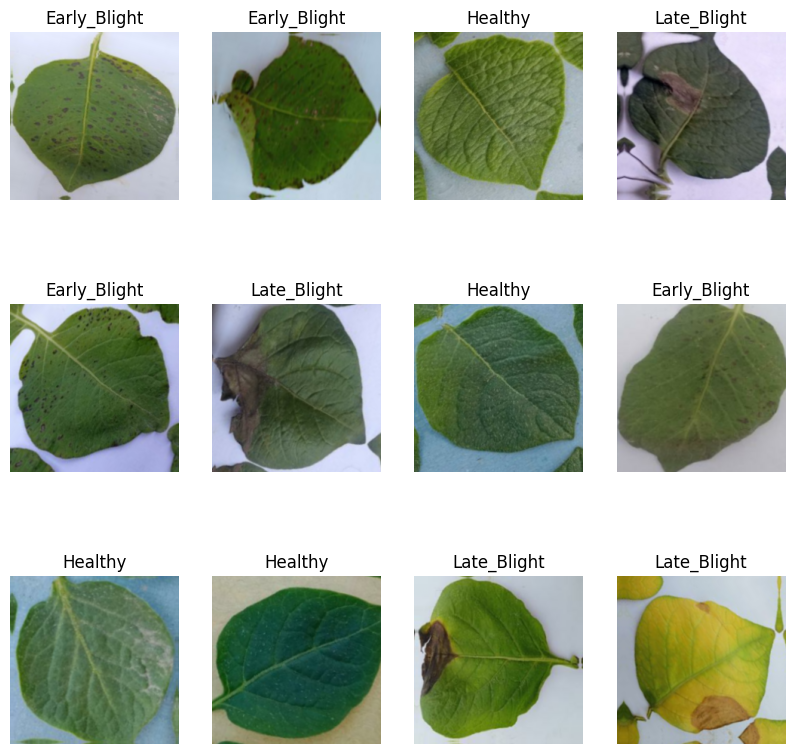

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy())  # Images are in [0,1]
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.4755 - loss: 1.5639 - val_accuracy: 0.3393 - val_loss: 5.0279
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6725 - loss: 0.7273 - val_accuracy: 0.3393 - val_loss: 7.8545
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7477 - loss: 0.5900 - val_accuracy: 0.3393 - val_loss: 13.1104
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7979 - loss: 0.4987 - val_accuracy: 0.3393 - val_loss: 7.8073
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7965 - loss: 0.4858 - val_accuracy: 0.3393 - val_loss: 11.4660
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8320 - loss: 0.3773 - val_accuracy: 0.3929 - val_loss: 4.1910
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8576 - loss: 0.3750 - val_accuracy: 0.3438 - val_loss: 5.2964
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8943 - loss: 0.2780 - val_accuracy: 0.3705 

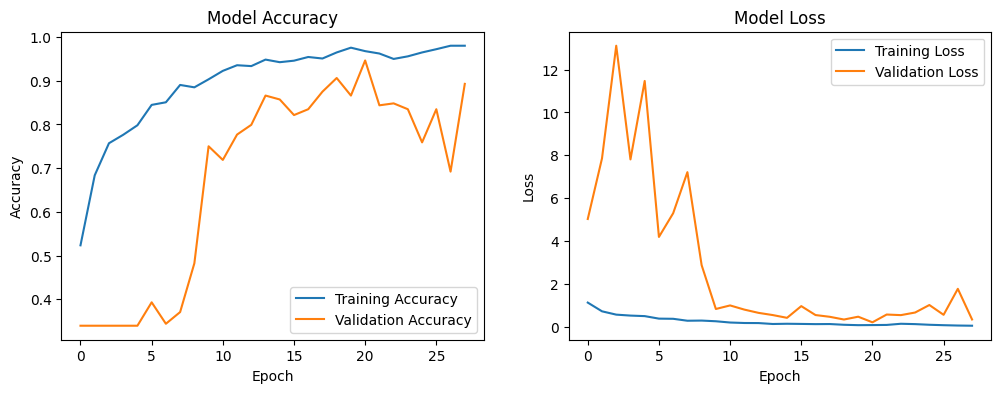

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Calculate class weights (adjust based on imbalance check output)
# Example: If Early_Blight: 1000, Healthy: 500, Late_Blight: 1023
class_counts = [1000, 500, 1023]  # Replace with actual counts from Cell 5
total = sum(class_counts)
class_weights = {i: total / (len(class_names) * count) for i, count in enumerate(class_counts)}

# Define deeper CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile model with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
import numpy as np
from PIL import Image

def predict_image_from_path(file_path):
    # Load and preprocess image
    img = Image.open(file_path).convert('RGB')
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))  # Match training image size
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = np.max(prediction[0])
    print(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f})")
    print(f"Prediction Probabilities: {prediction[0]}")
    return predicted_class

# Example usage with multiple test images
test_images = [
    '/kaggle/input/potato-dataset-1/potato_dataset/Late_Blight/Late_Blight_1000.jpg',
    '/kaggle/input/potato-dataset-1/potato_dataset/Early_Blight/Early_Blight_100.jpg',
    '/kaggle/input/potato-dataset-1/potato_dataset/Healthy/Healthy_100.jpg'
]

for img_path in test_images:
    print(f"\nTesting image: {img_path}")
    predict_image_from_path(img_path)


Testing image: /kaggle/input/potato-dataset-1/potato_dataset/Late_Blight/Late_Blight_1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
Predicted Class: Late_Blight (Confidence: 1.00)
Prediction Probabilities: [5.1761614e-08 8.2238666e-15 1.0000000e+00]

Testing image: /kaggle/input/potato-dataset-1/potato_dataset/Early_Blight/Early_Blight_100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Class: Early_Blight (Confidence: 1.00)
Prediction Probabilities: [9.9972683e-01 2.7267938e-04 5.0421085e-07]

Testing image: /kaggle/input/potato-dataset-1/potato_dataset/Healthy/Healthy_100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Class: Healthy (Confidence: 0.82)
Prediction Probabilities: [0.16950065 0.8224252  0.00807412]


In [21]:
from PIL import Image
import numpy as np


def predict_image_from_path(file_path):
    # Load and preprocess image
    img = Image.open(file_path).convert('RGB')
    img = img.resize((224, 224))  # Match your model input size
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    print(f"✅ Predicted Class: {predicted_class}")
    return predicted_class

# 🔍 Example usage
predict_image_from_path('/kaggle/input/potato-dataset-1/potato_dataset/Early_Blight/Early_Blight_1.jpg')  # change path and filename


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
✅ Predicted Class: Early_Blight


'Early_Blight'

In [22]:
model.save('potato.h5')